In [16]:
from matplotlib import pyplot as plt
import numpy as np
import os
import random

import joblib

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

NUM_POINTS = 50

In [17]:
data = []

for root, subdirs, files in os.walk('/Users/lgx/2.Semester/ITT/UE6/lstm_demo/xml_logs'):
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in tqdm(files):
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                scaler = StandardScaler()
                points = scaler.fit_transform(points)
                
                resampled = resample(points, NUM_POINTS)
                
                data.append((label, resampled))

  0%|          | 0/150 [00:00<?, ?it/s]

In [18]:
print(data[0])

('delete_mark', array([[-0.78899123,  1.68329284],
       [-1.25697283,  1.64908508],
       [-0.93277516,  1.4759012 ],
       [-0.71502293,  1.18829376],
       [-0.29513583,  0.87511113],
       [ 0.11237526,  0.50060478],
       [ 0.40212079,  0.30733168],
       [ 0.72021664, -0.04385007],
       [ 0.89588076, -0.19282201],
       [ 1.066854  , -0.40400357],
       [ 1.18483239, -0.56784903],
       [ 1.23368809, -0.66889983],
       [ 1.26955323, -0.77151867],
       [ 1.29555204, -0.83540505],
       [ 1.29631362, -0.87764999],
       [ 1.31554554, -0.92039753],
       [ 1.30697045, -0.93894211],
       [ 1.30715513, -0.96110253],
       [ 1.25008878, -0.97423473],
       [ 1.21467781, -0.9795461 ],
       [ 1.04948733, -0.97533405],
       [ 0.71879653, -0.96468629],
       [ 0.35166445, -0.95168279],
       [-0.14982526, -0.92686423],
       [-0.54878969, -0.88302293],
       [-0.84986326, -0.85343246],
       [-1.13323128, -0.81007647],
       [-1.29681308, -0.76873931],
    

## Let's have a look at our data

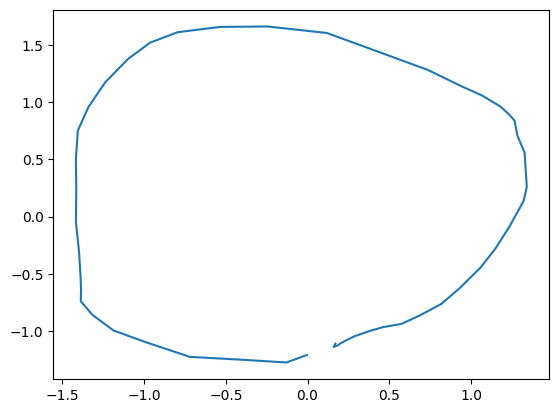

In [19]:
test_data = random.sample(data, 1)[0]

label = test_data[0]
sequence = test_data[1]
sequence

plt.plot(sequence.T[0], sequence.T[1]*-1)

In [20]:
# Prepare the data
labels = [sample[0] for sample in data]

print(set(labels))

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)
encoder.fit(labels)

joblib.dump(encoder, 'label_encoder.pkl')

print(set(labels_encoded))

y = to_categorical(labels_encoded)

print(len(y[0]))

sequences = [sample[1] for sample in data]
X = np.array(sequences)

X_train = X
y_train = y

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

{'check', 'rectangle', 'delete_mark', 'pigtail', 'right_sq_bracket', 'left_sq_bracket', 'right_curly_brace', 'caret', 'triangle', 'circle', 'left_curly_brace', 'x', 'v', 'arrow', 'star'}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
15
(120, 50, 2) (30, 50, 2) (120, 15) (30, 15)


In [21]:
# Define the model
model = Sequential()

# add LSTM layer
# input shape is (length of an individual sample, dimensions of the sample)
# in our case: two dimensions, as we have X and Y coordinates

# old syntax
#model.add(LSTM(64, input_shape=(NUM_POINTS, 2)))

# new syntax
model.add(Input((NUM_POINTS, 2)))
model.add(LSTM(64))

# add dense layer to do machine learning magic
model.add(Dense(32, activation='relu'))

# here, you can add more layers and maybe a dropout for better performance

# softmax layer for classification
model.add(Dense(len(set(labels)), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [22]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    #validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.0856 - loss: 2.6532 - val_accuracy: 0.2667 - val_loss: 2.5722 - learning_rate: 0.0010
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2423 - loss: 2.5836 - val_accuracy: 0.3000 - val_loss: 2.5107 - learning_rate: 0.0010
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2852 - loss: 2.5138 - val_accuracy: 0.3333 - val_loss: 2.4488 - learning_rate: 0.0010
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3450 - loss: 2.4551 - val_accuracy: 0.3667 - val_loss: 2.3880 - learning_rate: 0.0010
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3765 - loss: 2.3902 - val_accuracy: 0.3667 - val_loss: 2.3213 - learning_rate: 0.0010
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3435 - loss: 2.3138 - val_accuracy: 0.3667 - val_loss: 2.2488 - learning_rate: 0.0010
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3685 - loss: 2.2226 - val_accuracy: 0.3667 -

In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │           495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,183 (231.19 KB)

 Trainable params: 19,727 (77.06 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 39,456 (154.13 KB)

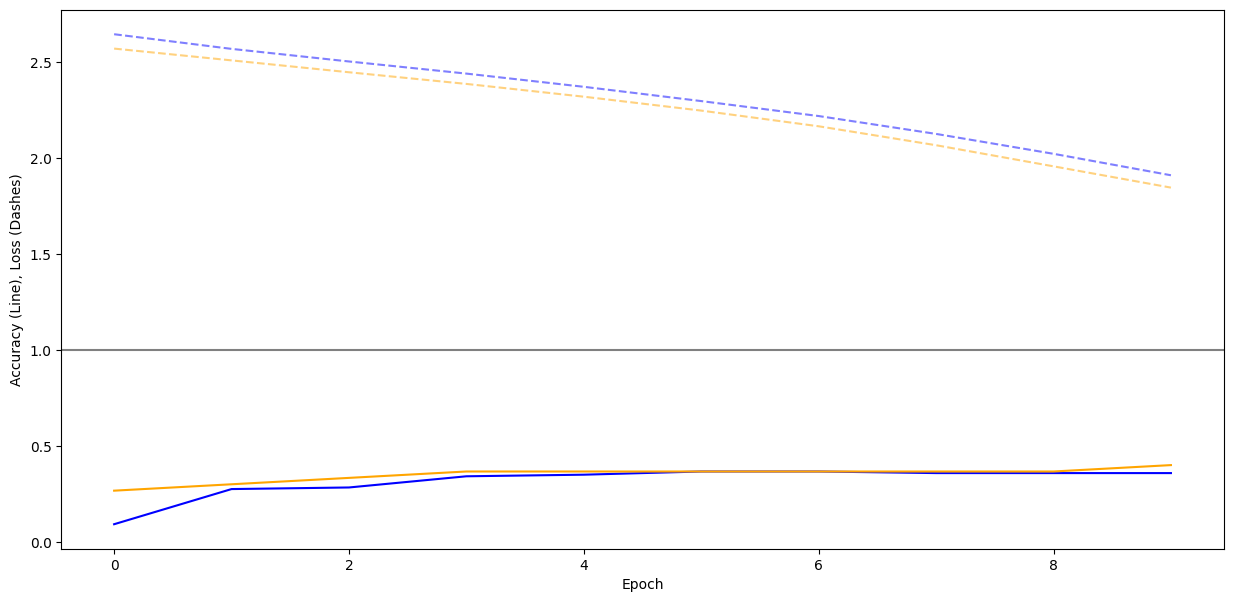

In [24]:
loss = history.history['loss']
#val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
#val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
#plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
#plt.plot(val_loss, '--', color='orange', alpha=0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


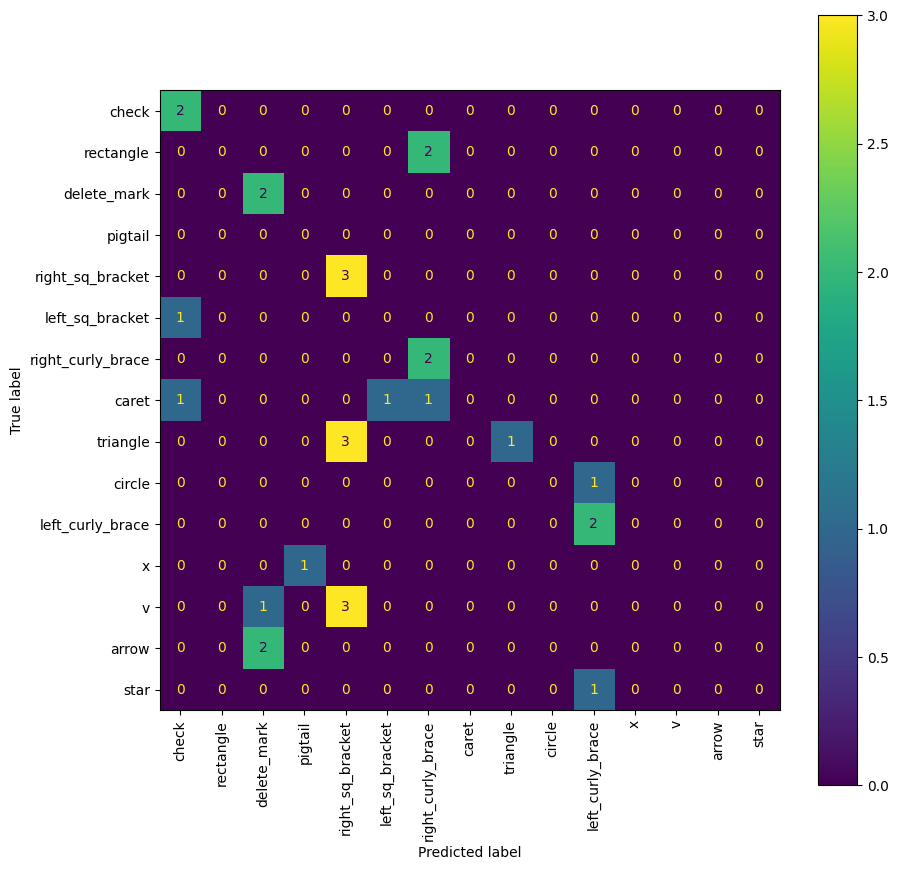

In [25]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels)).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Label:      check
Prediction: check


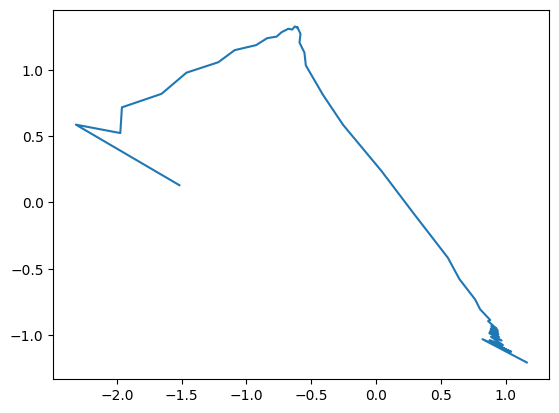

In [26]:
# lets test the model in action

test_data = random.sample(data, 1)[0]

label = test_data[0]
sequence = test_data[1]
sequence

plt.plot(sequence.T[0], sequence.T[1]*-1)

prediction = model.predict(np.array([sequence]))
prediction = np.argmax(prediction)

prediction_label = encoder.inverse_transform(np.array([prediction]))[0]

print('Label:     ', label)
print('Prediction:', prediction_label)

In [27]:
correct_predictions = 0
total_attempts = 0

for sample in data:
    label = sample[0]
    sequence = sample[1]
    sequence


    prediction = model.predict(np.array([sequence]))
    prediction = np.argmax(prediction)

    prediction_label = encoder.inverse_transform(np.array([prediction]))[0]
    
    if label == prediction_label:
        correct_predictions += 1
    total_attempts += 1
accuracy = correct_predictions / total_attempts
print(accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step